# Intercranial Hemorrhage (ICH) Subtypes Detection Project

**Notebook Content**

1. [Summary](#Summary)
2. [Import Libraries](#Import-Libraries)
3. [Set Seed](#Set-Seed)
4. [Data Handling](#Data-Handling)
    - 4.1 [Declearing Data Paths](#Declaring-Data-Paths)
    - 4.2 [Reading Data](#Reading-Data)
    - 4.3 [Check Duplicates](#Check-Duplicates)
    - 4.4 [Data Reformatting](#Data-Reformatting)
5. [Configuration](#Configuration)
6. [Data Split](#Data-Split)
    - 6.1 [Train Test Split](#Train-Test-Split)
    - 6.2 [Test Validation Split](#Test-Validation-Split)
    - 6.3 [Concat each dataset with its labels](#Concat-Dataset)
7. [Preprocessing](#Preprocessing)
    - 7.1 [Transforms](#Transforms)
        - 7.1.1 [LoadDcm](#LoadDcm)
        - 7.1.2 [Correcting Window](#Correcting-Window)
        - 7.1.3 [Denoise Image](#Denoise-Image)
        - 7.1.4 [Crop Image](#Crop-Image)
    - 7.2 [Preprocessing Pipeline](#Preprocessing-Pipeline)
        - 7.2.1 [Training Pipeline](#Training-Pipeline)
        - 7.2.3 [Testing Pipeline](#Testing-Pipeline)
8. [Custom Dataset and DataLoader](#Custom-Dataset-Data-Loader)
    - 8.1 [Custom Dataset](#Custom-Dataset)
    - 8.2 [Data Loader](#Data-Loader)
        - 8.2.1 [Train Data Loader](#Train-Data-Loader)
        - 8.2.2 [Val Data Loader](#Val-Data-Loader)
        - 8.2.3 [Test Data Loader](#Test-Data-Loader)
9. [Modeling](#Modeling)
   - 9.1 [Training](#Training)
       - 9.1.1 [Configure Model CheckPoint Callback](#Configure-Model-CheckPoint-Callback)
       - 9.1.2 [Loss Functions](#Loss-Functions)
           - 9.1.2.1 [BCE Loss](#BCE-Loss)
           - 9.1.2.1 [Focal Loss](#Focal-Loss)
       - 9.1.3 [Model Experiments](#Model-Experiments)
            - Changing Loss function on the same architecture
                - 9.1.3.1 [DenseNet201 Model with BCEWithLogits Loss](#DenseNet201-Model-with-BCEWithLogits-Loss)
                - 9.1.3.2 [DenseNet201 Model with Focal Loss](#DenseNet201-Model-with-Focal-Loss)
            - Changing Model Architecture with the winner loss function
                - 9.1.3.3 [EfficientNetB0 Model with Focal Loss](#EfficientNetB0-Model-with-Focal-Loss)
                - 9.1.3.4 [EfficientNetB3 Model with Focal Loss](#EfficientNetB3-Model-with-Focal-Loss)
            - Changing in Preprocessing with the winner architecture
                - 9.1.3.5 [DenseNet201 with Focal Loss and 3 channels](#DenseNet201-with-Focal-Loss-and-3-channels)
         - 9.1.4 [The Winner Model](#The-Winner-Model)
   - 9.2 [Evaluation](#Evaluation)
   - 9.3 [Error Analysis](#Error-Analysis)

## **1. Summary** <a id='Summary'></a>

During the project, we aimed to develop a robust model for detecting intracranial hemorrhages from medical images. The initial analysis of the train DataFrame revealed a significant class imbalance, with 644,870 normal exams and 107,933 abnormal exams comprising five subtypes: epidural, intraparenchymal, intraventricular, subarachnoid, and subdural.

To address the class imbalance, we decided to balance the number of normal and abnormal exams during the training process. Additionally, we employed weighted loss for the subtypes to tackle the imbalance issue effectively. The test set and validation set were set to 10% each.

In the preprocessing phase, custom classes were created to work seamlessly with Monai transforms. These included LoadDcm to read DICOM paths, CorrectingWindow to apply specific window level and width, DenoiseImage to remove noise, and CropScaleImage to crop the brain area and scale the image.

Two preprocessing pipelines were defined:

train_transform: Comprising the four custom stages alongside resizing the image to (224, 224) and applying Random Zoom and RandAffine with rotate and translate ranges for data augmentation.
test_transform: Similar to train_transform but without Random Zoom and RandAffine, used for validation and test sets to ensure consistent evaluation.
A custom Dataset was implemented to return transformed images and their labels for the DataLoader. To handle corrupted images, None was returned for those instances. Additionally, a custom collate_fn was created to filter out None values, ensuring smooth data loading during training. DataLoaders were set up for each dataset with a batch size of 32.

For the modeling phase, several experiments were conducted:

Model Checkpoint Callback: A callback was created to save the best model checkpoint during training.
Loss Functions: Binary Cross Entropy with Logits and Focal Loss were used, with appropriate class weights to address the imbalance.
Model Architecture Experiments:

3.1 **Changing loss function on the same model architecture**
    - DenseNet201: BCEWithLogits achieved an F1-score of 78.4%, and Focal Loss achieved 82%.

3.2 **Changing Model Architecture with the winner loss function**
    - EfficientNetB0 and EfficientNetB3: EfficientNetB0 achieved a score of 79%, while EfficientNetB3 reached 81.6%.

3.3 **Preprocessing Enahncement with the winner architecture**
    - Preprocessing Enhancement: A 3-channel image was created by stacking brain window, subdural window, and bone window together, achieving a score of 79%.

The combination of Densenet201 and Focal Loss stood out as the best-performing architecture and loss function, achieving an impressive F1-score of 82% on test set.

## **2. Import Libraries** <a id='Import-Libraries'></a>

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 1.0 MB/s eta 0:00:0000:0100:17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 3.2 MB/s eta 0:00:0000:0100:010m
  Using cached https://download.pytorch.org/whl/networkx-3.0-py3-none-any.whl (2.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 3.3 MB/s eta 0:00:0000:0100:01
  Using cached https://download.pytorch.org/whl/sympy-1.11.1-py3-none-any.whl (6.5 MB)
  Using cached https://download.pytorch.org/whl/filelock-3.9.0-py3-none-any.whl (9.7 kB)
  Using cached https://download.pytorch.org/whl/cmake-3.25.0-py2.py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (23.7 MB)
  Using cached https://download.pytorch.org/whl/lit-15.0.7.tar.gz (132 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 3.7 MB/s eta 0:00:

In [2]:
!pip install tqdm numpy pandas pydicom pytorch-lightning\
monai torchmetrics scikit-learn matplotlib seaborn opencv-contrib-python\
    lightning tensorboard tensorboardx

  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 3.6 MB/s eta 0:00:0000:0100:01
  Using cached pydicom-2.4.2-py3-none-any.whl (1.8 MB)
  Using cached pytorch_lightning-2.0.5-py3-none-any.whl (722 kB)
  Using cached monai-1.2.0-202306081546-py3-none-any.whl (1.3 MB)
  Using cached torchmetrics-1.0.1-py3-none-any.whl (729 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 3.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 3.6 MB/s eta 0:00:0000:0100:01
  Using cached opencv_contrib_python-4.8.0.74-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (67.8 MB)
  Using cached lightning-2.0.5-py3-none-any.whl (1.9 MB)
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Using cached fsspec-2023.6.0-py3-none-any.whl (163 kB)
  Using cached lightning_utilities-0.9.0-py3-none-any.whl (23 kB)
  Using cached threadpo

In [3]:
import torch
import lightning.pytorch as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorboard
from sklearn.model_selection import train_test_split
import torchmetrics
import pydicom
import monai
import os
from pathlib import Path
import random
import cv2
import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.__version__

'2.0.1+cu118'

## **3. Set Seed** <a id="Set-Seed"></a>

In [3]:
SEED = 42
torch.manual_seed(SEED)
# GPU operation has separate seed
if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)
monai.utils.set_determinism(seed=SEED)
pl.seed_everything(SEED)

Global seed set to 42


42

## **4. Data Handling** <a id = "Data-Handling"></a>

### **4.1 Declaring Data Paths** <a id="Declaring-Data-Paths"></a>

In [4]:
CUR_PATH = Path().absolute()
ROOT_DATA_DIR = Path("rsna-intracranial-hemorrhage-detection")
TRAINING_IMAGES_PATH = Path("stage_2_train")
TRAINING_CSV_PATH = Path("stage_2_train.csv")

### **4.2 Reading Data** <a id='Reading-Data'></a>

In [5]:
train_df = pd.read_csv(ROOT_DATA_DIR/TRAINING_CSV_PATH)
train_df.head(10)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
5,ID_12cadc6af_any,0
6,ID_38fd7baa0_epidural,0
7,ID_38fd7baa0_intraparenchymal,0
8,ID_38fd7baa0_intraventricular,0
9,ID_38fd7baa0_subarachnoid,0


### **4.3 Check Duplicates** <a id='Check-Duplicates'></a>

In [6]:
train_df.duplicated().sum()

24

In [7]:
train_df.drop_duplicates(inplace=True)

### **4.4 Data Reformatting** <a id='Data-Reformatting'></a>
Regarding the dataframe above, It contains six rows for the same dicom file. Each row contains DicomPath and subtype label.

Recreating the dataframe with Dicom Path and its subtype in two seperated columns.

In [8]:
def recreate_table(df, splitter = "_"):
    """
    
    This function is used for recreating table with the right shape of path and labels
    
        Parameters:
            df (Datframe) : The dataframe that has two columns ID = "ID_<filename>_<subtype>", label = 0 or 1
            splitter(str) : the splitter used to split the ID string
    
        Returns:
            new_df (Dataframe): a new dataframe with the right shape
            
    """
    new_df = df.copy()

    # Splitting the ID column into two columns; file_name, subtypes
    new_df["file_name"] = new_df["ID"].str.split(splitter, n=2, expand=True)[1]
    new_df["Subtype"] = new_df["ID"].str.split(splitter, n=2, expand=True)[2]

    # Rename each id into ID_<filename>_.dcm
    new_df["ID"] = new_df["file_name"].apply(lambda name: "ID_"+name+".dcm")
    new_df.drop("file_name", axis=1, inplace=True)

    #Changing the subtypes rows into columns with labels as values
    new_df_pivot = new_df.pivot(index = "ID", columns="Subtype", values="Label")
    new_df_pivot.reset_index(inplace=True)
    new_df_pivot.rename_axis(None, axis=1, inplace=True)
    return new_df_pivot

train_df_new = recreate_table(train_df)
train_df_new.head()

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf.dcm,0,0,0,0,0,0
1,ID_000039fa0.dcm,0,0,0,0,0,0
2,ID_00005679d.dcm,0,0,0,0,0,0
3,ID_00008ce3c.dcm,0,0,0,0,0,0
4,ID_0000950d7.dcm,0,0,0,0,0,0


**Exploring the size of normal and abnormal exams**

In [9]:
abnormal_exams = train_df_new[train_df_new["any"]==1]
normal_exams = train_df_new[train_df_new["any"]==0]
print(f"Abnormal Exams Size is {abnormal_exams.shape[0]}\nNormal Exams Size is {normal_exams.shape[0]}")

Abnormal Exams Size is 107933
Normal Exams Size is 644870


**Exploring the subtypes size**

In [10]:
for subtype in train_df_new.columns[2:]:
    df = train_df_new[train_df_new[subtype]==1]
    print(f"The size of {subtype} is {df.shape[0]}\n")

The size of epidural is 3145

The size of intraparenchymal is 36118

The size of intraventricular is 26205

The size of subarachnoid is 35675

The size of subdural is 47166



**Regarding the stats above:**
 - The normal exams size is 6 times more than abnormal ones.
     - So, for training process, we will use the size of normal exams as the same as the size of abnormal exams
     
     
 - There is unbalance between subtypes in abnormal exams.
     - So, for training process, we will use weighted loss 

**Choosing normal exams with size the same as abnormal exams**

In [11]:
normal_exams_new_size = normal_exams.sample(n = abnormal_exams.shape[0],
                                      replace=False, 
                                      random_state=SEED,
                                      ignore_index=True
                                      )
normal_exams_new_size

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_1c6bfb61e.dcm,0,0,0,0,0,0
1,ID_c59dfca21.dcm,0,0,0,0,0,0
2,ID_f339f98d4.dcm,0,0,0,0,0,0
3,ID_bfd1b9b9f.dcm,0,0,0,0,0,0
4,ID_0c0326411.dcm,0,0,0,0,0,0
...,...,...,...,...,...,...,...
107928,ID_75253a3fb.dcm,0,0,0,0,0,0
107929,ID_99dbd823d.dcm,0,0,0,0,0,0
107930,ID_a3fcf0fe8.dcm,0,0,0,0,0,0
107931,ID_6b874c8e4.dcm,0,0,0,0,0,0


**Create the dataframe that will be used in the training process**

In [12]:
dcm_dataframe = pd.concat([normal_exams_new_size, abnormal_exams], axis=0, ignore_index=True)
dcm_dataframe

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_1c6bfb61e.dcm,0,0,0,0,0,0
1,ID_c59dfca21.dcm,0,0,0,0,0,0
2,ID_f339f98d4.dcm,0,0,0,0,0,0
3,ID_bfd1b9b9f.dcm,0,0,0,0,0,0
4,ID_0c0326411.dcm,0,0,0,0,0,0
...,...,...,...,...,...,...,...
215861,ID_fffc60817.dcm,1,0,1,1,0,0
215862,ID_fffd00949.dcm,1,0,0,0,1,0
215863,ID_fffe2edb8.dcm,1,0,1,1,0,0
215864,ID_ffff922b9.dcm,1,0,0,1,0,0


## **5. Configuration** <a id="Configuration"></a>

In [13]:
config = {
    "test_size" : 0.1,
    "val_size": 0.1,
    "image_shape": (224,224),
    "batch_size": 32,
    
    "optimizer": { "lr": 1e-3,},
    
    "loss": { "pos_weights": [1.4142, 8.2848, 2.4447, 2.8701, 2.4599, 2.1393]},
    
    "model":{ "num_classes": 6,
              "in_channels":1,
              "spatial_dims":2,
              "epochs": 5,
                    
            },
}

## **6. Data Split** <a id="Data-Split"></a>

- The data will be splitted into 80% training and 10% validation and 10% testing

In [14]:
X = dcm_dataframe["ID"]
y = dcm_dataframe.drop("ID", axis=1)

### **6.1 Train-Test Split** <a id="Train-Test-Split"></a>

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size= config["val_size"] + config["test_size"],
                                                    random_state=SEED,
                                                    shuffle=True,
                                                    stratify=y
                                                   )

**Ensuring about the percentage of columns' size in train and test sets**

In [16]:
print(f"The size of training set is {X_train.shape[0]/X.shape[0]} and testing set is {X_test.shape[0]/X.shape[0]}")
for col in y.columns:
    print(f"The size of {col} in training set is {y_train[y_train[col]==1].shape[0]/y[y[col]==1].shape[0]}"
          f" and testing set is {y_test[y_test[col]==1].shape[0]/y[y[col]==1].shape[0]}")

The size of training set is 0.799996293997202 and testing set is 0.20000370600279804
The size of any in training set is 0.799996293997202 and testing set is 0.20000370600279804
The size of epidural in training set is 0.8 and testing set is 0.2
The size of intraparenchymal in training set is 0.7999889251896561 and testing set is 0.2000110748103439
The size of intraventricular in training set is 0.8 and testing set is 0.2
The size of subarachnoid in training set is 0.8 and testing set is 0.2
The size of subdural in training set is 0.7999830386295212 and testing set is 0.20001696137047872


### **6.2 Test-Validation Split** <a id="Test-Validation-Split"></a>

In [17]:
X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                y_test,
                                                test_size= config["val_size"]/(config["val_size"] + config["test_size"]),
                                                random_state=SEED,
                                                shuffle=True,
                                                stratify=y_test
                                               )

**Ensuring about the percentage of columns' size in validation and test sets**

In [18]:
print(f"The size of training set is {X_val.shape[0]/X.shape[0]}"
      f"and testing set is {X_val.shape[0]/X.shape[0]}")

for col in y.columns:
    print(f"The size of {col} in training set is {y_val[y_val[col]==1].shape[0]/y[y[col]==1].shape[0]}"
          f" and testing set is {y_test[y_test[col]==1].shape[0]/y[y[col]==1].shape[0]}")

The size of training set is 0.10000185300139902and testing set is 0.10000185300139902
The size of any in training set is 0.10000648550489656 and testing set is 0.09999722049790148
The size of epidural in training set is 0.10015898251192369 and testing set is 0.0998410174880763
The size of intraparenchymal in training set is 0.10000553740517194 and testing set is 0.10000553740517194
The size of intraventricular in training set is 0.09998091967181835 and testing set is 0.10001908032818164
The size of subarachnoid in training set is 0.10001401541695866 and testing set is 0.09998598458304135
The size of subdural in training set is 0.10000848068523936 and testing set is 0.10000848068523936


### **6.3 Concat each dataset with its labels** <a id="Concat-Dataset"></a>

In [19]:
train_dataframe = pd.concat([X_train, y_train], axis = 1).reset_index(drop=True)
val_dataframe = pd.concat([X_val, y_val], axis = 1).reset_index(drop=True)
test_dataframe =  pd.concat([X_test, y_test], axis = 1).reset_index(drop=True)

## **7. Preprocessing** <a id="Preprocessing"></a>

### **7.1 Transforms** <a id="Transforms"></a>

In [20]:
from monai.transforms.compose import Transform

#### **7.1.1 LoadDcm** <a id="LoadDcm"></a>

In [21]:
class LoadDcm(Transform):
    """
    
    This is class created to be used in monai.transforms.compose to load the DICOM object
    
    """
    def __init__(self):
        pass;
    
    def __call__(self, dcm_file_path):
        """
        
        This function returns DICOM object that contains metadata and image
        
        Args:
            dcm_file_path(Path): The DICOM file absolute path
        
        Returns: 
            DICOM object
            
        """
        return pydicom.dcmread(dcm_file_path)

#### **7.1.2 Correcting Window** <a id="Correcting-Window"></a>

In [22]:
class CorrectingWindow(Transform):
    """
    This class contains the helper functions needed to correct image windows
    
    """
    def __init__(self, window_level=None, window_width=None):
        
        """
         Args:
                window_level(int): Default is None. If None, the window level from metadata will be used
                window_width(int): Default is None. If None, the window width from metadata will be used
        
        """
        self.window_level = window_level
        self.window_width = window_width
    
    def get_first_dicom_field_int(self, value):
        """

        This function is used to get the first value of multiple values of DICOM metadata fields and convert it into integer

            Parameters: 
                value ([float, pydicom multival.MultiValue, pydicom.valuerep.DSfloat]): Metadata field value

            Returns:
                value(int): Converted value into integer

        """
        if type(value) == pydicom.multival.MultiValue:
            return int(value[0])
        else:
            return int(value)


    def transform_hu(self, image, intercept, slope):
        """

        This function is used to transfer the image pixel values to Hounisfield Unit (HU)

            Parameters: 
                image(np.array): It's a DICOM image

            Returns: 
                HU_image(np.array): A new image with HU transformation

        """
        hu_image = image* slope + intercept

        return hu_image

    def window_image(self, image, window_level, window_width):
        """

        This function is used to adjust an image containing HU values with a certain range of gray shades density

            Parameters: 
                image (np.array): An image with HU values
                window_level(int): The centre of the grayscale range
                window_width(int): The range of grayscale

            Returns: 
                window_image(np.array): A new image adjusted with window leval and window width

        """
        lowest_value = window_level - window_width // 2
        highest_value = window_level + window_width // 2

        window_image = image.copy()

        window_image[window_image < lowest_value] = lowest_value
        window_image[window_image > highest_value] = highest_value

        return window_image

    def window_hu_image(self, dcm_file, window_level=None, window_width=None):
        """

        This function is used to view the adjusted image by transform_HU and window_image functions

            Parameters: 
                dcm_file(DICOM): It's a DICOM file
                window_level(int): Windowlevel to be allied on the image 
                                   if None, it will be the window_level of the DICOM file
                window_width(int): Windowwidth to be applied on the image
                                    if None, it will be the window_width of the DICOM file


            Returns: 
                adjusted_image(np.array): An adjusted image after applying HU, window level and window width

        """
        if window_level and window_width:
            window_level_ = window_level
            window_width_ = window_width
        else:
            window_level_  = dcm_file.WindowCenter
            window_width_ = dcm_file.WindowWidth

        fields_list = [window_level_,
                       window_width_,
                       dcm_file.RescaleIntercept,
                       dcm_file.RescaleSlope
                      ]

        window_level, window_width, intercept, slope = [self.get_first_dicom_field_int(value) for value in fields_list]
        image = dcm_file.pixel_array
        hu_image = self.transform_hu(image, intercept, slope)

        adjusted_image = self.window_image(hu_image, window_level, window_width)
        
        return adjusted_image
    
    def __call__(self, dcm_obj):
        """
        Executing window_hu_image function with required arguments
        
            Args:
                dcm_obj: DICOM Object
            
            Returns:
                adjusted_image (np.array)
        
        """
        return self.window_hu_image(dcm_obj, self.window_level, self.window_width)    

#### **7.1.3 Denoise Image** <a id="Denoise-Image"></a>

In [23]:
class DenoiseImage(Transform):
    """
    
    This class contains functions to remove noise from image
    
    """
    def __init__(self,  kernel_size=(3,3)):
       """     
            Args:
                kernel_size(tuple): This is the kernel size used for dialation
                       
       """
       self.kernel_size = kernel_size
    
    
    def denoise_image(self, image=None, kernel_size= None):
        """

        This function is used to remove the noise from the image

            Parameters:
                image(np.array): This image used to remove the noise from
                kernel_size(tuple): This is the kernel size used for dialation

            Returns:
                masked_image(np.array): This is the masked image

        """
        kernel = np.ones(kernel_size)

        segmentation = cv2.dilate(image.astype("uint8"),  kernel)
        retval, labels = cv2.connectedComponents(segmentation)

        # Getting the number of clsases or segmentation found
        label_count = np.bincount(labels.ravel().astype("int8"))

        #the first class is background, we won't use it
        label_count[0] = 0

        mask = labels == label_count.argmax()
        mask = cv2.dilate(mask.astype("uint8"), kernel)
        masked_image = mask* image

        return  masked_image
    
    def __call__(self, image):
        """
        
        This function to execute denoise_image function
        
            Parameters:
                image(np.array): This image used to remove the noise from
                
            Returns:
                masked_image(np.array): This is the masked image

        """
        return self.denoise_image(image=image, kernel_size=self.kernel_size)

#### **7.1.4 Crop Image** <a id="Crop-Image"></a>

In [24]:
class CropScaleImage(Transform):
    """
    
    This class contains functions to crop image
    
    """
    def __init__(self, is_scale=False, scale_factor=1):
        """
         Args:
            is_scale(bool): to scale the image
            scale_factor(float): scaling image with this number if is_scale = True
        
        """
        self.is_scale = is_scale
        self.scale_factor = scale_factor
        
    def crop_scale_image(self, image, is_scale=False, scale_factor=1):
        """

        This functio is used to crop the image to filt the object in the center

            Parameters:
                image(np.array): This is the image needed to be cropped
                is_scale(bool): to scale the image
                scale_factor(float): scaling image with this number if is_scale = True

            Returns:
                cropped_image(np.array): This is the final output

        """
        # Create a mask with the background pixels
        mask = image == 0

        # gitting the coordinates of the object which pixel values !=0

        coords = np.transpose(np.nonzero(~mask))
        # Find the object area
        if coords.size !=0:
            x_min, y_min = np.min(coords, axis = 0)
            x_max, y_max = np.max(coords, axis=0)

            # Crop image
            cropped_image = image[x_min:x_max,
                                  y_min:y_max]
        else:
            cropped_image = image
        if is_scale:
            cropped_image = cropped_image.astype("float32") * scale_factor

        return cropped_image
    
    def __call__(self, image):
        """
        
        This function to execute crop_image function
        
            Parameters:
                image(np.array): This is the image needed to be cropped

            Returns:
                cropped_image(np.array): This is the final output

        """
        return self.crop_scale_image(image=image, is_scale=self.is_scale, scale_factor = self.scale_factor)

### **7.2 Preprocessing Pipeline** <a id="Preprocessing-Pipeline"></a>

In [25]:
from monai.transforms import Compose, Resize, EnsureChannelFirst, ToTensor, RandAffine, RandZoom

#### **7.2.1 Training Pipeline** <a id="Training-Pipeline"></a>

In [26]:
train_transform = Compose(
    [
        LoadDcm(),
        CorrectingWindow(),
        DenoiseImage(),
        CropScaleImage(is_scale=True, scale_factor = 1/3071),
        ToTensor(),
        EnsureChannelFirst(channel_dim="no_channel"),
        Resize(config["image_shape"]),
        RandZoom(min_zoom = 0.9, max_zoom = 1.1),
        RandAffine(rotate_range=(-5,5), translate_range=(0,0.05))
     ]
)

#### **7.2.2 Testing Pipeline** <a id="Testing-Pipeline"></a>

In [27]:
test_transform = Compose(
    [
        LoadDcm(),
        CorrectingWindow(),
        DenoiseImage(),
        CropScaleImage(is_scale=True, scale_factor = 1/3071),
        ToTensor(),
        EnsureChannelFirst(channel_dim="no_channel"),
        Resize(config["image_shape"]),
    ]
)

## **8. Custom Dataset and Data Loader** <a id="Custom-Dataset-Data-Loader"></a>

In [28]:
from monai.data import Dataset

### **8.1 Custom Dataset** <a id="Custom-Dataset"></a>

In [29]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, path_col, transform):
        """
        This is a custom dataset class to load dicom data from dataframe.
        :param dataframe(DataFrame): dataframe that contains data which is file name and labels
        :param root_dir(Path): the absolute path name of image dir 
        :param path_col(str): the column name of the image paths
        :param transform: the transforms to be applied to the images
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.path_col = path_col
        self.label_cols = self.dataframe.drop(path_col, axis=1)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            image_file = self.root_dir/(self.dataframe.loc[idx, self.path_col])
            labels = torch.tensor(self.label_cols.iloc[idx])
    
            return self.transform(image_file), labels
        except:
            return None, None

### **8.2 Data Loader** <a id="Data-Loader"></a>

The collate_fn is created to handle the corrupted images. The corrupted images will be filtered out.
**Pros:** The corrupted images will not be used for training. and the training will not be interrupted.
**Cons:** it slightly increases the training time.

In [63]:
from monai.data import DataLoader
from torch.utils.data.dataloader import default_collate

# To handle corrupted images
def collate_fn(batch):
    # Filter out any samples where the data or label is None (i.e., corrupted)
    batch = [(data, label) for data, label in batch if data is not None and label is not None]
    return default_collate(batch)

**8.2.1 Train Data Loader** <a id="Train-Data-Loader"></a>

In [64]:
train_dataset = CustomDataset(dataframe = train_dataframe,
                              root_dir = ROOT_DATA_DIR/TRAINING_IMAGES_PATH,
                              path_col = "ID",
                              transform = train_transform
                             )

train_data_loader = DataLoader(dataset = train_dataset,
                              batch_size=config["batch_size"],
                              shuffle=False,
                               collate_fn=collate_fn
                              )

**8.2.2 Val Data Loader** <a id="Val-Data-Loader"></a>

In [65]:
val_dataset = CustomDataset(dataframe = val_dataframe,
                              root_dir = ROOT_DATA_DIR/TRAINING_IMAGES_PATH,
                              path_col = "ID",
                              transform = test_transform
                             )

val_data_loader = DataLoader(dataset = val_dataset,
                              batch_size=config["batch_size"],
                              shuffle=False,
                               collate_fn=collate_fn
                            )

**8.2.3 Test Data Loader** <a id="Test-Data-Loader"></a>

In [66]:
test_dataset = CustomDataset(dataframe = test_dataframe,
                              root_dir = ROOT_DATA_DIR/TRAINING_IMAGES_PATH,
                              path_col = "ID",
                              transform = test_transform
                             )

test_data_loader = DataLoader(dataset = test_dataset,
                              batch_size=config["batch_size"],
                              shuffle=False,
                              collate_fn=collate_fn
                             )

**Ensure about the output of dataloader**

In [34]:
images, labels = next(iter(train_data_loader))
print(f"The image batch shape is {images.shape}")
print(f"The label batch shape is {labels.shape}")

The image batch shape is torch.Size([32, 1, 224, 224])
The label batch shape is torch.Size([32, 6])


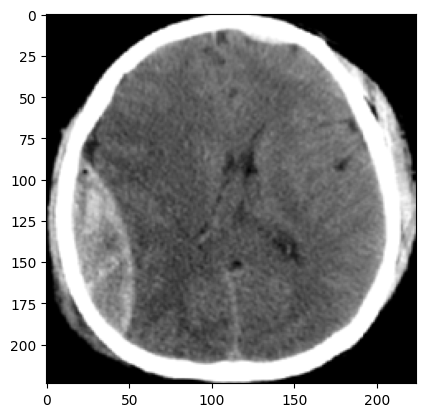

In [35]:
image = np.array(images[6,0,:,:])
plt.imshow(image, cmap="gray")

In [36]:
labels[6]

tensor([1, 1, 0, 0, 0, 0])

## 9. Modeling <a id="Modeling"></a>

### 9.1 Training <a id="Training"></a>

#### 9.1.1 Configure Model CheckPoint Callback <a id="Configure-Model-CheckPoint-Callback"></a>

In [67]:
from lightning.pytorch.callbacks import  ModelCheckpoint

In [68]:
MODELS_PATH = CUR_PATH/"models"
os.makedirs(MODELS_PATH, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
        monitor='val_f1',
        save_top_k=1,
        mode='max',
        dirpath=MODELS_PATH,
        filename='model-{epoch:02d}-{val_f1:.2f}',
        every_n_epochs=1
)

#### 9.1.2 Loss Functions <a id="Loss-Functions"></a>

**First we calculate the percentage for each class in the data to calculate the class weight**

In [70]:
import torch.nn as nn
class_size_dict = {}

# Calculate each subtype size in the dataset
for col in train_dataframe.columns[1:]:
    class_size_dict[col] = train_dataframe[train_dataframe[col]==1].shape[0]

# Calculating the size of whole data
Total_size = train_dataframe.shape[0]

# Calculate the weights of each category
class_weight_dict = {k: np.sqrt(Total_size / v) for k, v in class_size_dict.items()}
class_weight_dict

{'any': 1.4142135623730951,
 'epidural': 8.284776392445,
 'intraparenchymal': 2.444737731600963,
 'intraventricular': 2.8701132531420215,
 'subarachnoid': 2.459852833719919,
 'subdural': 2.139346824171592}

In [71]:
pos_weights = torch.FloatTensor(list(class_weight_dict.values()))
config['loss']['pos_weights'] = pos_weights

##### 9.1.2.1 BCE Loss <a id="BCE-Loss"></a>

In [72]:
bce_loss_logits = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

##### 9.1.2.2 Focal Loss <a id="Focal-Loss"></a>

In [73]:
from monai.losses import FocalLoss
focal_loss = FocalLoss(weight = pos_weights)

#### 9.1.3 Model Experiments <a id="Model-Experiments"></a>

#####  Declaring Model Class <a id="Declaring-Model-Class"></a>

In [75]:
import torchvision
import torch.optim as optim
from IPython.display import HTML, display

In [76]:
class HemorrhageModel(pl.LightningModule):
    def __init__(self, engine, loss, lr, num_classes):
        
        """
        
        This class is used to define the model
        
        :param engine (model): the model module from monai.networks.nets
        :param loss (loss object): loss function
        :param num_classes (int): Number of classes
        :param lr (float): learning rate value

        """
        super().__init__()
        self.engine = engine
        self.lr = lr
        self.loss_fn = loss
        self.num_classes = num_classes
        self.optimizer = optim.Adam(self.engine.parameters(), lr = self.lr)
        self.train_f1 = torchmetrics.F1Score(task= 'binary', num_classes=self.num_classes)
        self.val_f1 = torchmetrics.F1Score(task= 'binary', num_classes=self.num_classes)

    def forward(self, data):
        pred = self.engine(data)
        return pred
    
    
    def configure_optimizers(self):
        return [self.optimizer]
    
    def training_step(self, batch, batch_idx):
        """
        This function is used to define the training step
        :param batch: the batch of data
        :param batch_idx: the batch index
        :return: the loss
        """
        images, labels = batch
        labels = labels.float()
        pred = self(images)
        loss = self.loss_fn(pred, labels)
        self.log("train_loss",
                 loss,
                 on_step=True,
                 on_epoch=True,
                 prog_bar=True,
                 logger=True
                )
        self.log("train_f1",
                 self.train_f1(pred, labels.int()),
                 on_step=True,
                 on_epoch=True,
                 prog_bar=True,
                 logger=True
                )
        return loss
    
    def validation_step(self, batch, batch_idx):
        """
        This function is used to define the validation step
        :param batch: the batch of data
        :param batch_idx: the batch index
        :return: the loss
        
        """
        images, labels = batch
        labels = labels.float()
        pred = self(images)
        loss = self.loss_fn(pred, labels)
        self.log("val_loss",
                 loss,
                 on_step=True,
                 on_epoch=True,
                 prog_bar=True,
                 logger=True
                )
        self.log("val_f1",
                 self.val_f1(pred, labels.int()),
                 on_step=True,
                 on_epoch=True,
                 prog_bar=True,
                 logger=True
                )


##### 9.1.3.1 DenseNet201 Model with BCEWithLogits Loss <a id="DenseNet201-Model-with-BCEWithLogits-Loss"></a>

In [47]:
from monai.networks.nets import DenseNet201
engine =  DenseNet201(spatial_dims = config['model']['spatial_dims'],
                      in_channels = config['model']['in_channels'],
                      out_channels = config['model']['num_classes'],
                      pretrained=True
                     )

In [48]:
model = HemorrhageModel(engine = engine,
                       loss=bce_loss_logits,
                       lr=config['optimizer']['lr'],
                       num_classes = config['model']['num_classes'] 
                       )

**The model stopped training at epoch 3, so I loaded the last epoch checkpoint and trained it with another two epochs.**

In [55]:
checkpoint_dict = torch.load("models/model-epoch=02-val_f1=0.78.ckpt")
model_state_dict = checkpoint_dict['state_dict']
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [47]:
# Creating folder for logs
from pytorch_lightning.loggers import TensorBoardLogger
LOGS_PATH = CUR_PATH/"logs"
os.makedirs(LOGS_PATH, exist_ok = True)

In [57]:
trainer = pl.Trainer(devices = torch.cuda.device_count(),
                     accelerator = "auto",
                     max_epochs=config['model']['epochs'],
                    logger= TensorBoardLogger(save_dir=LOGS_PATH, log_graph=True, name="densenet201_BCEWithLogitsLoss"),
                    log_every_n_steps = 1,
                    callbacks = [checkpoint_callback],
                    enable_progress_bar= True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [58]:
trainer.fit(model, train_data_loader, val_data_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | engine   | DenseNet201       | 18.1 M
1 | loss_fn  | BCEWithLogitsLoss | 0     
2 | train_f1 | BinaryF1Score     | 0     
3 | val_f1   | BinaryF1Score     | 0     
-----------------------------------------------
18.1 M    Trainable params
0         Non-trainable params
18.1 M    Total params
72.393    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


![training and evaluation losses](logs_img/BCE/DenseNetBCELoss.png)

![f1 score for training and validation](logs_img/BCE/f1_DenseNetBCE.png)

##### 9.1.3.2 DenseNet201 Model with Focal Loss <a id="DenseNet201-Model-with-Focal-Loss"></a>

In [50]:
model = HemorrhageModel(engine = engine,
                        loss=focal_loss,
                       lr=config['optimizer']['lr'],
                       num_classes = config['model']['num_classes']
                       )

In [51]:
# Creating new folder for model
MODEL_PATH = CUR_PATH/"DenseNet201_FocalLoss"
os.makedirs(MODEL_PATH, exist_ok = True)
checkpoint_callback.dirpath = MODEL_PATH

In [52]:
trainer = pl.Trainer(devices = torch.cuda.device_count(),
                     accelerator = "auto",
                     max_epochs=config['model']['epochs'],
                    logger= TensorBoardLogger(save_dir=LOGS_PATH, log_graph=True, name="densenet201_FocalLoss"),
                    log_every_n_steps = 1,
                    callbacks = [checkpoint_callback],
                    enable_progress_bar= True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [68]:
trainer.fit(model, train_data_loader, val_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type          | Params
-------------------------------------------
0 | engine   | DenseNet201   | 18.1 M
1 | loss_fn  | FocalLoss     | 0     
2 | train_f1 | BinaryF1Score | 0     
3 | val_f1   | BinaryF1Score | 0     
-------------------------------------------
18.1 M    Trainable params
0         Non-trainable params
18.1 M    Total params
72.393    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


![](logs_img/dense_focal/DenseFocalLoss.png)

![](logs_img/dense_focal/f1_Dense_focal.png)

**After using BCE with Logits and Focal Loss function, We found that the model performance improved when using Focal Loss**
**Let's do another experiment by using Focal loss with Different architectures to find a better model**

##### 9.1.3.3 EfficientNetB0 with Focal Loss  <a id="EfficientNetB0-with-Focal-Loss"></a>

In [83]:
from monai.networks.nets import EfficientNetBN
engine =  EfficientNetBN(model_name = "efficientnet-b0",
                      spatial_dims = config['model']['spatial_dims'],
                      in_channels = config['model']['in_channels'],
                      num_classes = config['model']['num_classes'],
                      pretrained=True
                      )

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /home/kyrillos/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:05<00:00, 3.61MB/s]


In [84]:
model = HemorrhageModel(engine = engine,
                       loss=focal_loss,
                       lr=config['optimizer']['lr'],
                       num_classes = config['model']['num_classes']
                       )

In [85]:
# Creating new folder for model
MODEL_PATH = CUR_PATH/"EfficientNetB0_FocalLoss"
os.makedirs(MODEL_PATH, exist_ok = True)
checkpoint_callback.dirpath = MODEL_PATH

In [86]:
trainer = pl.Trainer(devices = torch.cuda.device_count(),
                     accelerator = "auto",
                     max_epochs=config['model']['epochs'],
                    logger= TensorBoardLogger(save_dir=LOGS_PATH, log_graph=True, name="EffiecientB0_FocalLoss"),
                    log_every_n_steps = 1,
                    callbacks = [checkpoint_callback],
                    enable_progress_bar= True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [87]:
trainer.fit(model, train_data_loader, val_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type           | Params
--------------------------------------------
0 | engine   | EfficientNetBN | 4.0 M 
1 | loss_fn  | FocalLoss      | 0     
2 | train_f1 | BinaryF1Score  | 0     
3 | val_f1   | BinaryF1Score  | 0     
--------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.059    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


![](logs_img/EfficientB0_focal/EfficientB0Focalloss.png)

![](logs_img/EfficientB0_focal/f1_EfficientB0Focalloss.png)

##### 9.1.3.4 EfficientNetB3  Model with Focal Loss <a id="EfficientNetB3-Model-with-Focal-Loss"></a>

In [50]:
from monai.networks.nets import EfficientNetBN
engine =  EfficientNetBN(model_name = "efficientnet-b3",
                      spatial_dims = config['model']['spatial_dims'],
                      in_channels = config['model']['in_channels'],
                      num_classes = config['model']['num_classes'],
                      pretrained=True
                      )

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /home/kyrillos/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:41<00:00, 1.18MB/s]


In [51]:
model = HemorrhageModel(engine = engine,
                        loss=focal_loss,
                       lr=config['optimizer']['lr'],
                       num_classes = config['model']['num_classes']
                       )

In [52]:
# Creating new folder for model
MODEL_PATH = CUR_PATH/"EfficientNetB3_FocalLoss"
os.makedirs(MODEL_PATH, exist_ok = True)
checkpoint_callback.dirpath = MODEL_PATH

In [53]:
trainer = pl.Trainer(devices = torch.cuda.device_count(),
                     accelerator = "auto",
                     max_epochs=config['model']['epochs'],
                    logger= TensorBoardLogger(save_dir=LOGS_PATH, log_graph=True, name="EffiecientB3_FocalLoss"),
                    log_every_n_steps = 1,
                    callbacks = [checkpoint_callback],
                    enable_progress_bar= True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [54]:
trainer.fit(model, train_data_loader, val_data_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type           | Params
--------------------------------------------
0 | engine   | EfficientNetBN | 10.7 M
1 | loss_fn  | FocalLoss      | 0     
2 | train_f1 | BinaryF1Score  | 0     
3 | val_f1   | BinaryF1Score  | 0     
--------------------------------------------
10.7 M    Trainable params
0         Non-trainable params
10.7 M    Total params
42.819    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


![](logs_img/EffiecientB3_focal/EfficientB3Focalloss.png)

![](logs_img/EffiecientB3_focal/f1_EfficientB3Focalloss.png)

**We used EfficientNetB0 and B3, but found that the performance of DenseNet201 has the best performance**

**We will move to improve the preprocessing phase by stacking the images with different windows together in one image**

##### 9.1.3.5 DenseNet201 with Focal Loss and 3 channels <a id="DenseNet201-with-Focal-Loss-and-3-channels"></a>

We will make changes in correcting window class to generate an image with 3 windows; brain, subdural and bone.

In [48]:
class CorrectingWindow3windows(Transform):
    """
    This class contains the helper functions needed to correct image windows

    """
    def __init__(self, is_scale=False, scale_factor=1):
        """
         Args:
            scale(bool): to scale the image
            scale_factor(float): scaling image with this number if is_scale = True

        """
        self.is_scale = is_scale
        self.scale_factor = scale_factor
    def get_first_dicom_field_int(self, value):
        """

        This function is used to get the first value of multiple values of DICOM metadata fields and convert it into integer

            Parameters:
                value ([float, pydicom multival.MultiValue, pydicom.valuerep.DSfloat]): Metadata field value

            Returns:
                value(int): Converted value into integer

        """
        if type(value) == pydicom.multival.MultiValue:
            return int(value[0])
        else:
            return int(value)


    def transform_hu(self, image, intercept, slope):
        """

        This function is used to transfer the image pixel values to Hounisfield Unit (HU)

            Parameters:
                image(np.array): It's a DICOM image

            Returns:
                HU_image(np.array): A new image with HU transformation

        """
        hu_image = image* slope + intercept

        return hu_image

    def window_image(self, image, window_level, window_width, is_scale=False, scale_factor= 1):
        """

        This function is used to adjust an image containing HU values with a certain range of gray shades density

            Parameters:
                image (np.array): An image with HU values
                window_level(int): The centre of the grayscale range
                window_width(int): The range of grayscale

            Returns:
                window_image(np.array): A new image adjusted with window leval and window width

        """
        lowest_value = window_level - window_width // 2
        highest_value = window_level + window_width // 2

        window_image = image.copy()

        window_image[window_image < lowest_value] = lowest_value
        window_image[window_image > highest_value] = highest_value

        return window_image

    def window_hu_image(self, dcm_file, is_scale=False, scale_factor=1):
        """

        This function is used to view the adjusted image by transform_HU and window_image functions

            Parameters:
                dcm_file(DICOM): It's a DICOM file
            Returns:
                adjusted_image(np.array): An adjusted image after applying HU, window level and window width

        """

        fields_list = [
                       dcm_file.RescaleIntercept,
                       dcm_file.RescaleSlope
                      ]

        intercept, slope = [self.get_first_dicom_field_int(value) for value in fields_list]
        image = dcm_file.pixel_array
        hu_image = self.transform_hu(image, intercept, slope)
        brain_window = self.window_image(hu_image, window_level=40, window_width= 80)
        subdural_window = self.window_image(hu_image, window_level=80, window_width= 200)
        bone_window = self.window_image(hu_image, window_level=600, window_width= 2800)

        adjusted_image = np.concatenate([brain_window[..., np.newaxis],
                                         subdural_window[..., np.newaxis],
                                         bone_window[..., np.newaxis]], axis = -1)
        if is_scale:
            return adjusted_image.astype(np.float32) * scale_factor
        else:
            adjusted_image

    def __call__(self, dcm_obj):
        """
        Executing window_hu_image function with required arguments

            Args:
                dcm_obj: DICOM Object

            Returns:
                np.array()

        """
        return self.window_hu_image(dcm_obj, self.is_scale, self.scale_factor)

In [49]:
train_transform_3channels = Compose(
    [
        LoadDcm(),
        CorrectingWindow3windows(is_scale=True, scale_factor=1/3071),
        ToTensor(),
        EnsureChannelFirst(channel_dim=-1),
        Resize(config["image_shape"]),
        RandZoom(min_zoom = 0.9, max_zoom = 1.1),
        RandAffine(rotate_range=(-5,5), translate_range=(0,0.05))
     ]
)

In [50]:
test_transform_3channels = Compose(
    [
        LoadDcm(),
        CorrectingWindow3windows(is_scale=True, scale_factor=1/3071),
        ToTensor(),
        EnsureChannelFirst(channel_dim=-1),
        Resize(config["image_shape"]),
    ]
)

In [51]:
train_dataset = CustomDataset(dataframe = train_dataframe,
                              root_dir = ROOT_DATA_DIR/TRAINING_IMAGES_PATH,
                              path_col = "ID",
                              transform = train_transform_3channels
                             )

train_data_loader = DataLoader(dataset = train_dataset,
                              batch_size=config["batch_size"],
                              shuffle=False
                               )

In [52]:
val_dataset = CustomDataset(dataframe = val_dataframe,
                              root_dir = ROOT_DATA_DIR/TRAINING_IMAGES_PATH,
                              path_col = "ID",
                              transform = test_transform_3channels
                             )

val_data_loader = DataLoader(dataset = val_dataset,
                              batch_size=config["batch_size"],
                              shuffle=False
                             )

In [53]:
test_dataset = CustomDataset(dataframe = test_dataframe,
                              root_dir = ROOT_DATA_DIR/TRAINING_IMAGES_PATH,
                              path_col = "ID",
                              transform = test_transform_3channels
                             )

test_data_loader = DataLoader(dataset = test_dataset,
                              batch_size=config["batch_size"],
                              shuffle=False
                              )

In [55]:
from monai.networks.nets import DenseNet201
engine =  DenseNet201(spatial_dims = config['model']['spatial_dims'],
                      in_channels = 3,
                      out_channels = config['model']['num_classes'],
                      pretrained=True
                     )

In [59]:
model_3channels = HemorrhageModel(engine = engine,
                        loss=focal_loss,
                       lr=config['optimizer']['lr'],
                       num_classes = config['model']['num_classes']
                       )

In [60]:
# Creating new folder for model
MODEL_PATH = CUR_PATH/"DenseNet201_3channels_FocalLoss"
os.makedirs(MODEL_PATH, exist_ok = True)
checkpoint_callback.dirpath = MODEL_PATH

In [61]:
trainer = pl.Trainer(devices = torch.cuda.device_count(),
                     accelerator = "auto",
                     max_epochs=config['model']['epochs'],
                    logger= TensorBoardLogger(save_dir=LOGS_PATH, log_graph=True, name="densenet201_3channels_FocalLoss"),
                    log_every_n_steps = 1,
                    callbacks = [checkpoint_callback],
                    enable_progress_bar= True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [62]:
trainer.fit(model_3channels, train_data_loader, val_data_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type          | Params
-------------------------------------------
0 | engine   | DenseNet201   | 18.1 M
1 | loss_fn  | FocalLoss     | 0     
2 | train_f1 | BinaryF1Score | 0     
3 | val_f1   | BinaryF1Score | 0     
-------------------------------------------
18.1 M    Trainable params
0         Non-trainable params
18.1 M    Total params
72.418    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


![](logs_img/Densenet3channels_focal/Dense3channelsFocal.png)

![](logs_img/Densenet3channels_focal/f1_Dense3channelsFocal.png)

**The model of Densenet201 with focal loss on one channel (brain window) has better performance than 3 channels**

#### 9.1.4 The Winner Model <a id="The-Winner-Model"> </a>


![](logs_img/all.png)
![](logs_img/labels.png)

**As we can see the winner model is Densenet201 with FocalLoss on one channel**

### 9.2 Evaluation  <a id="Evaluation"></a>


Due to the Densenet201 model with Focal Loss has the best performance, we will use it for evaluation.

In [104]:
from monai.networks.nets import DenseNet201
engine =  DenseNet201(spatial_dims = config['model']['spatial_dims'],
                      in_channels = config['model']['in_channels'],
                      out_channels = config['model']['num_classes'],
                      pretrained=True
                     )

In [105]:
model = HemorrhageModel(engine = engine,
                       loss=focal_loss,
                       lr=config['optimizer']['lr'],
                       num_classes = config['model']['num_classes']
                       )

In [117]:
checkpoint_dict = torch.load("DenseNet201_FocalLoss/model-epoch=03-val_f1=0.82.ckpt")
model_state_dict = checkpoint_dict['state_dict']
model.load_state_dict(model_state_dict)
model.to("cuda")

HemorrhageModel(
  (engine): DenseNet201(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (layers): Sequential(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
        )
        (denselayer2): _Dens

In [127]:
from tqdm.notebook import tqdm
from monai.transforms import Activations
model.eval()
predictions_list = []
labels_list = []
with torch.no_grad():
    for images, labels in tqdm(test_data_loader):
        preds = model(images.to("cuda"))
        preds = Activations(sigmoid=True)(preds)
        preds = preds.cpu().numpy() >= 0.5
        predictions_list.extend(preds.astype(int))
        labels_list.extend(labels.cpu().numpy())

  0%|          | 0/675 [00:00<?, ?it/s]

**Using F1 Metric to evaluate the model**

In [145]:
f1_metric = torchmetrics.F1Score(task="binary", num_classes=6)
f1_metric(torch.tensor(predictions_list), torch.tensor(labels_list))

tensor(0.8192)

**Using Classification Report to evaluate the model**

In [133]:
from sklearn.metrics import classification_report
print(classification_report(labels_list, predictions_list, target_names = test_dataframe.columns[1:]))

                  precision    recall  f1-score   support

             any       0.92      0.90      0.91     10793
        epidural       0.56      0.50      0.52       314
intraparenchymal       0.89      0.73      0.80      3612
intraventricular       0.90      0.76      0.83      2621
    subarachnoid       0.71      0.68      0.70      3567
        subdural       0.72      0.76      0.74      4717

       micro avg       0.84      0.80      0.82     25624
       macro avg       0.78      0.72      0.75     25624
    weighted avg       0.84      0.80      0.82     25624
     samples avg       0.41      0.40      0.40     25624



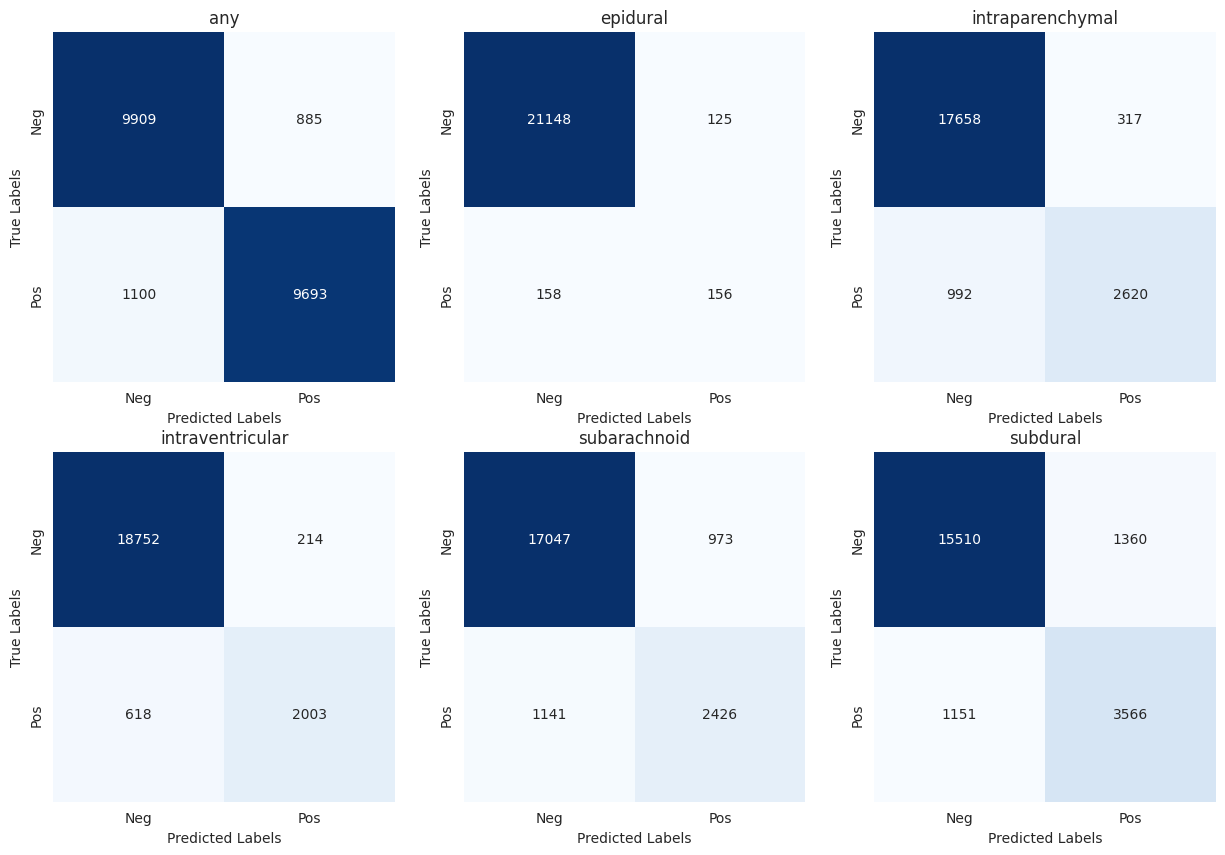

In [160]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
conf_matrix = multilabel_confusion_matrix(labels_list, predictions_list)
labels = test_dataframe.columns[1:]
fig, axes = plt.subplots(2,3, figsize=(15, 10))
axes = axes.flatten()
for i, class_conf in enumerate(conf_matrix):
    sns.heatmap(class_conf, annot=True, fmt="d", cbar=False, cmap="Blues", xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"], ax=axes[i])
    axes[i].set_xlabel("Predicted Labels")
    axes[i].set_ylabel("True Labels")
    axes[i].set_title(f"{labels[i]}")
    axes[i].xaxis.set_ticklabels(["Neg", "Pos"])
    axes[i].yaxis.set_ticklabels(["Neg", "Pos"])


### 9.3 Error Analysis  <a id="Error-Analysis"></a>

**Getting a random example from subdural type that the model failed to detect**

In [194]:
subdural_idx = np.where((np.array(labels_list)[:, -1] == 1) & (np.array(predictions_list)[:, -1] == 0))[0]
subdural_random_idx = np.random.choice(subdural_idx, 1)[0]

In [195]:
subdural_random_idx

21330

**Getting the predictions**

In [196]:
subdural_prediction = np.array(predictions_list)[subdural_random_idx]
subdural_prediction

array([1, 0, 0, 1, 0, 0])

**Getting the true labels**

In [197]:
subdural_label = np.array(labels_list)[subdural_random_idx]
subdural_label

array([1, 0, 0, 1, 0, 1])

**The model predicts this image as only intraparenchymal but its labels are subdural and intraparenchymal**

In [198]:
subdural_file_path = ROOT_DATA_DIR/TRAINING_IMAGES_PATH /test_dataframe.iloc[subdural_random_idx]['ID']
img = test_transform(subdural_file_path)

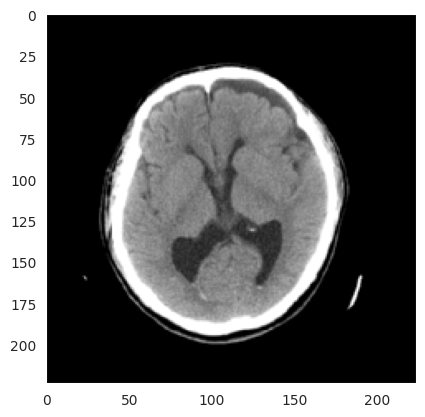

In [203]:
plt.imshow(np.array(img)[0], cmap="gray")
plt.grid(False)

**From the image above, it's shown that, this patient had two subtypes of Hemorrhage.**